# **Set Up**

In [ ]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.layers import Input, Dense, Embedding, Flatten, Dropout, merge, Activation, BatchNormalization, LeakyReLU
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras import initializers
from tensorflow.python.keras.layers import add, concatenate
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.python.keras.models import model_from_json
from sklearn import preprocessing
from keras.utils import plot_model
import datetime

from tensorflow import keras 
import tensorflow as tf
print("Keras version " + keras.__version__)
print("Tensorflow version " + tf.__version__)

print("Panda version " + pd.__version__)

Keras version 2.4.0
Tensorflow version 2.4.1
Panda version 1.1.5


In [ ]:
# mounting google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# **Data Loading and Preprocessing**

In [ ]:
base_path = '/content/drive/My Drive/DATA2040_Final_Project_YARD'
MOVIELENS_DIR = base_path + '/data/'
USER_DATA_FILE = 'users.dat'
MOVIE_DATA_FILE = 'movies.dat'
RATING_DATA_FILE = 'ratings.dat'

AGES = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
OCCUPATIONS = { 0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                4: "college/grad student", 5: "customer service", 6: "doctor/health care",
                7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
                12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
                17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }

RATINGS_CSV_FILE = 'ml1m_ratings.csv'
USERS_CSV_FILE = 'ml1m_users.csv'
MOVIES_CSV_FILE = 'ml1m_movies.csv'

In [ ]:
ratings = pd.read_csv(os.path.join(MOVIELENS_DIR, RATING_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'movieid', 'rating', 'timestamp'])

max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
ratings['user_emb_id'] = ratings['userid'] - 1
ratings['movie_emb_id'] = ratings['movieid'] - 1
print(len(ratings), 'ratings loaded')
ratings.to_csv(MOVIELENS_DIR  + RATINGS_CSV_FILE, 
               sep='\t', 
               header=True, 
               encoding='latin-1', 
               columns=['user_emb_id', 'movie_emb_id', 'rating', 'timestamp'])
print('Saved to', RATINGS_CSV_FILE)
print(ratings.head())
print(ratings.shape)

1000209 ratings loaded
Saved to ml1m_ratings.csv
   userid  movieid  rating  timestamp  user_emb_id  movie_emb_id
0       1     1193       5  978300760            0          1192
1       1      661       3  978302109            0           660
2       1      914       3  978301968            0           913
3       1     3408       4  978300275            0          3407
4       1     2355       5  978824291            0          2354
(1000209, 6)


In [ ]:
users = pd.read_csv(os.path.join(MOVIELENS_DIR, USER_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'gender', 'age', 'occupation', 'zipcode'])
users['age_desc'] = users['age'].apply(lambda x: AGES[x])
users['occ_desc'] = users['occupation'].apply(lambda x: OCCUPATIONS[x])
print(len(users), 'descriptions of', max_userid, 'users loaded.')
users['user_emb_id'] = users['userid'] - 1
users.to_csv(MOVIELENS_DIR + USERS_CSV_FILE, 
             sep='\t', 
             header=True, 
             encoding='latin-1',
             columns=['user_emb_id', 'gender', 'age', 'occupation', 'zipcode', 'age_desc', 'occ_desc'])
print('Saved to', USERS_CSV_FILE)
print(users.head())
print(users.shape)

6040 descriptions of 6040 users loaded.
Saved to ml1m_users.csv
   userid gender  age  ...  age_desc              occ_desc user_emb_id
0       1      F    1  ...  Under 18          K-12 student           0
1       2      M   56  ...       56+         self-employed           1
2       3      M   25  ...     25-34             scientist           2
3       4      M   45  ...     45-49  executive/managerial           3
4       5      M   25  ...     25-34                writer           4

[5 rows x 8 columns]
(6040, 8)


In [ ]:
movies = pd.read_csv(os.path.join(MOVIELENS_DIR, MOVIE_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movieid', 'title', 'genre'])
print(len(movies), 'descriptions of', max_movieid, 'movies loaded.')
movies['movie_emb_id'] = movies['movieid'] - 1
movies.to_csv(MOVIELENS_DIR + MOVIES_CSV_FILE, 
              sep='\t', 
              header=True, 
              columns=['movie_emb_id', 'title', 'genre'])
print('Saved to', MOVIES_CSV_FILE)
print(movies.head())
print(movies.shape)

3883 descriptions of 3952 movies loaded.
Saved to ml1m_movies.csv
   movieid  ... movie_emb_id
0        1  ...            0
1        2  ...            1
2        3  ...            2
3        4  ...            3
4        5  ...            4

[5 rows x 4 columns]
(3883, 4)


In [ ]:
print(len(ratings['userid'].drop_duplicates()), 'of the', max_userid, 'users rate at least one movie.')

6040 of the 6040 users rate at least one movie.


In [ ]:
print(len(ratings['movieid'].drop_duplicates()), 'of the', max_movieid, 'movies are rated.')

3706 of the 3952 movies are rated.


In [ ]:
df = pd.read_csv(MOVIELENS_DIR + 'ml1m_ratings.csv',sep='\t', encoding='latin-1', 
                      usecols=['user_emb_id', 'movie_emb_id', 'rating', 'timestamp'])

#+1 is the real size, as they are zero based
num_users = df['user_emb_id'].unique().max() + 1
num_movies = df['movie_emb_id'].unique().max() + 1
df.head(5)

,user_emb_id,movie_emb_id,rating,timestamp
0,0,1192,5,978300760
1,0,660,3,978302109
2,0,913,3,978301968
3,0,3407,4,978300275
4,0,2354,5,978824291


In [ ]:
train_df, test_df = train_test_split(df,
                                     stratify=df['user_emb_id'],
                                     test_size=0.1,
                                     random_state=999613182)

In [ ]:
train_df, validate_df = train_test_split(train_df,
                                 stratify=train_df['user_emb_id'],
                                 test_size=0.1,
                                 random_state=999613182) #999613182

In [ ]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    if average:
      matrix = np.full((num_users, num_items), 0.0)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating
      avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
      inds = np.where(matrix == 0)
      matrix[inds] = np.take(avergae, inds[0])
      
    else:
      matrix = np.full((num_users, num_items), init_value)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

In [ ]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_train_zero = dataPreprocessor(train_df, num_users, num_movies, 0)
users_items_matrix_train_one = dataPreprocessor(train_df, num_users, num_movies, 1)
users_items_matrix_train_two = dataPreprocessor(train_df, num_users, num_movies, 2)
users_items_matrix_train_four = dataPreprocessor(train_df, num_users, num_movies, 4)
users_items_matrix_train_three = dataPreprocessor(train_df, num_users, num_movies, 3)
users_items_matrix_train_five = dataPreprocessor(train_df, num_users, num_movies, 5)
users_items_matrix_validate = dataPreprocessor(validate_df, num_users, num_movies, 0)
users_items_matrix_test = dataPreprocessor(test_df, num_users, num_movies, 0)
users_items_matrix_train_average = dataPreprocessor(train_df, num_users, num_movies, average=True)

In [ ]:
# Convert the matrix into the right detype
users_items_matrix_train_zero = users_items_matrix_train_zero.astype('float64')
users_items_matrix_train_one = users_items_matrix_train_one.astype('float64')
users_items_matrix_train_two = users_items_matrix_train_two.astype('float64')
users_items_matrix_train_three = users_items_matrix_train_three.astype('float64')
users_items_matrix_train_four = users_items_matrix_train_four.astype('float64')
users_items_matrix_train_five = users_items_matrix_train_five.astype('float64')
users_items_matrix_validate = users_items_matrix_validate.astype('float64')
users_items_matrix_test = users_items_matrix_test.astype('float64')
users_items_matrix_train_average = users_items_matrix_train_average.astype('float64')

# **Utility Functions**

In [ ]:
def show_error(history, skip, filename):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
    plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
    plt.title(filename) #'model train vs validation loss'
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.savefig(base_path + '/figures/plt/' + filename + '.jpg',bbox_inches='tight')
    plt.show()

In [ ]:
def show_rmse(history, skip, filename):
    rmse = history.history['masked_rmse_clip']
    val_rmse = history.history['val_masked_rmse_clip']
    plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
    plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
    plt.title(filename) #'model train vs validation masked_rmse'
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.savefig(base_path + '/figures/plt/' + filename + '.jpg',bbox_inches='tight')
    plt.show()

In [ ]:
def load_model(name):
  # load json and create model
  model_file = open('{}.json'.format(name), 'r')
  loaded_model_json = model_file.read()
  model_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights("{}.h5".format(name))
  print("Loaded model from disk")
  return loaded_model
  

In [ ]:
def save_model(name, model):
  # # serialize model to JSON
  model_json = model.to_json()
  with open("{}.json".format(name), "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights("{}.h5".format(name))
  print("Saved model to disk")

In [ ]:
def masked_se(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1)
        return masked_mse

In [ ]:
def masked_mse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse

In [ ]:
def masked_rmse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [ ]:
def masked_rmse_clip(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 5)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [ ]:
# Test custom cost function
y_pred = K.constant([[ 1, 1, 1, 1], 
                     [ 1, 1, 1, 10],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3]])
y_pred = K.constant([[ 1, 1, 1, 3]])
y_true = K.constant([[ 1, 1, 1, 1],
                     [ 1, 1, 1, 1],
                     [ 0, 1, 1, 1],
                     [ 0, 0, 1, 1],
                     [ 0, 0, 0, 1],
                     [ 0, 0, 0, 0]])
y_true = K.constant([[ 0, 0, 1, 1]])
true = K.eval(y_true)
pred = K.eval(y_pred)
loss = K.eval(masked_se(y_true, y_pred))
rmse = K.eval(masked_rmse(y_true, y_pred))

for i in range(true.shape[0]):
    print(true[i], pred[i], loss[i], rmse[i], sep='\t')

[0. 0. 1. 1.]	[1. 1. 1. 3.]	4.0	1.4142135


# **Deep Learning AutoEncoder Models**

# **AutoRec**

In [ ]:
def AutoRec_model(X, reg, first_activation, last_activation):
    '''
    AutoRec
        INPUT: 
          X: #_user X #_item matrix
          reg: L2 regularization parameter
          first_activation: activation function for first dense layer
          last_activation: activation function for second dense layer
        
        OUTPUT:
          Keras model
    
    '''
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, activation=first_activation, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model

In [ ]:
# AutoRec parameter
#reg =  0.0005
#reg = 0.00025
#reg = 0.0002
reg = 0.001
first_activation = 'elu'
last_activation = 'elu'
lr= 0.0001
#first_activation = 'selu'
#last_activation = 'selu'
#lr = 0.001

In [ ]:
# Build model

AutoRec = AutoRec_model(users_items_matrix_train_zero, reg, first_activation, last_activation)

AutoRec.compile(optimizer = Adam(lr=lr), loss=masked_mse, metrics=[masked_rmse_clip]) 
 
AutoRec.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
LatentSpace (Dense)          (None, 500)               1976500   
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1979952   
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


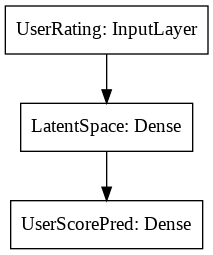

In [ ]:
plot_model(AutoRec, to_file= base_path + '/models/' + 'AutoRec.png')

In [ ]:
callbacks = [ModelCheckpoint(base_path + '/models/' + 'AutoRec.h5', save_best_only=True)]
hist_Autorec = AutoRec.fit(
    x=users_items_matrix_train_average, 
    y=users_items_matrix_train_zero,
    epochs= 500,  
    batch_size=256,
    verbose = 2, 
    validation_data=(users_items_matrix_train_average, users_items_matrix_validate),
    callbacks=callbacks)

Epoch 1/500
24/24 - 1s - loss: 7.3612 - masked_rmse_clip: 1.8905 - val_loss: 3.5442 - val_masked_rmse_clip: 1.3061
Epoch 2/500
24/24 - 0s - loss: 2.5437 - masked_rmse_clip: 1.1480 - val_loss: 2.0518 - val_masked_rmse_clip: 0.9844
Epoch 3/500
24/24 - 0s - loss: 1.8600 - masked_rmse_clip: 0.9692 - val_loss: 1.8173 - val_masked_rmse_clip: 0.9260
Epoch 4/500
24/24 - 0s - loss: 1.7386 - masked_rmse_clip: 0.9352 - val_loss: 1.7453 - val_masked_rmse_clip: 0.9123
Epoch 5/500
24/24 - 0s - loss: 1.6880 - masked_rmse_clip: 0.9276 - val_loss: 1.7111 - val_masked_rmse_clip: 0.9092
Epoch 6/500
24/24 - 0s - loss: 1.6630 - masked_rmse_clip: 0.9257 - val_loss: 1.6976 - val_masked_rmse_clip: 0.9120
Epoch 7/500
24/24 - 0s - loss: 1.6439 - masked_rmse_clip: 0.9251 - val_loss: 1.6847 - val_masked_rmse_clip: 0.9129
Epoch 8/500
24/24 - 0s - loss: 1.6293 - masked_rmse_clip: 0.9258 - val_loss: 1.6668 - val_masked_rmse_clip: 0.9123
Epoch 9/500
24/24 - 0s - loss: 1.6142 - masked_rmse_clip: 0.9255 - val_loss: 1.6

In [ ]:
# save history as dataframe
hist_Autorec_df = pd.DataFrame(hist_Autorec.history)

# save training history
pickle.dump(hist_Autorec.history, open(base_path + '/models/' + 'hist_Autorec_history' + '.pickle', "wb"))

# load baseline training data
hist_Autorec_history = open(base_path + '/models/' + 'hist_Autorec_history' + '.pickle', "rb")

# show baseline training history
hist_Autorec_df

,loss,masked_rmse_clip,val_loss,val_masked_rmse_clip
0,7.361218,1.890533,3.544203,1.306096
1,2.543692,1.147988,2.051759,0.984442
2,1.859982,0.969246,1.817255,0.926031
3,1.738571,0.935208,1.745334,0.912277
4,1.687987,0.927579,1.711143,0.909154
...,...,...,...,...
495,0.734524,0.732866,1.043260,0.876465
496,0.733545,0.732080,1.044910,0.878547
497,0.731836,0.730798,1.044037,0.878954
498,0.733058,0.731687,1.053617,0.884716


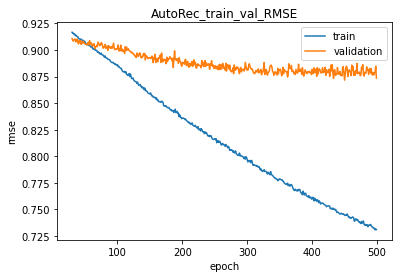

In [ ]:
show_rmse(hist_Autorec, 30, 'AutoRec_train_val_RMSE')

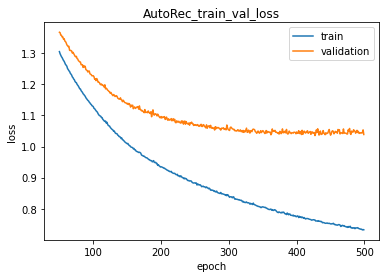

In [ ]:
show_error(hist_Autorec, 50, 'AutoRec_train_val_loss')

In [ ]:
AutoRec.load_weights(base_path + '/models/' + 'AutoRec.h5')
test_AutoRec_result = AutoRec.evaluate(users_items_matrix_train_average, users_items_matrix_test)

189/189 [==============================] - 0s 2ms/step - loss: 1.0368 - masked_rmse_clip: 0.8789


# **AutoRec LeakyRelu**

In [ ]:
def AutoRec_LReLU_model(X, reg):
    '''
    AutoRec
    LReLu is not implemented in to Dense 
    Need to have seperate LeakyRelu layer 
    '''
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    x = LeakyReLU()(x)
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred',kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model

In [ ]:
# Build model

AutoRec_LReLU = AutoRec_LReLU_model(users_items_matrix_train_zero, 0.0005)

AutoRec_LReLU.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) # learning rate too low
 
AutoRec_LReLU.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
LatentSpace (Dense)          (None, 500)               1976500   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 500)               0         
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1979952   
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


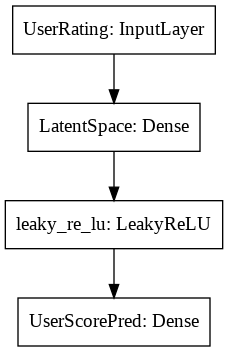

In [ ]:
plot_model(AutoRec_LReLU, to_file= base_path + '/models/' + 'AutoRec_LReLU.png')

In [ ]:
callbacks = [ModelCheckpoint(base_path + '/models/' + 'AutoRec_LReLU.h5', save_best_only=True)]
hist_AutoRec_LReLU = AutoRec_LReLU.fit(
    x=users_items_matrix_train_average, 
    y=users_items_matrix_train_zero,
    epochs= 500,  
    batch_size=256,
    verbose = 2, 
    validation_data=(users_items_matrix_train_average, users_items_matrix_validate),
    callbacks=callbacks)

Epoch 1/500
24/24 - 1s - loss: 7.2952 - masked_rmse_clip: 1.8448 - val_loss: 2.5741 - val_masked_rmse_clip: 1.1470
Epoch 2/500
24/24 - 0s - loss: 2.0484 - masked_rmse_clip: 1.0354 - val_loss: 1.8810 - val_masked_rmse_clip: 0.9425
Epoch 3/500
24/24 - 0s - loss: 1.7895 - masked_rmse_clip: 0.9405 - val_loss: 1.8111 - val_masked_rmse_clip: 0.9176
Epoch 4/500
24/24 - 0s - loss: 1.7558 - masked_rmse_clip: 0.9299 - val_loss: 1.7943 - val_masked_rmse_clip: 0.9150
Epoch 5/500
24/24 - 0s - loss: 1.7436 - masked_rmse_clip: 0.9286 - val_loss: 1.7845 - val_masked_rmse_clip: 0.9139
Epoch 6/500
24/24 - 0s - loss: 1.7345 - masked_rmse_clip: 0.9287 - val_loss: 1.7763 - val_masked_rmse_clip: 0.9146
Epoch 7/500
24/24 - 0s - loss: 1.7274 - masked_rmse_clip: 0.9291 - val_loss: 1.7717 - val_masked_rmse_clip: 0.9163
Epoch 8/500
24/24 - 0s - loss: 1.7196 - masked_rmse_clip: 0.9291 - val_loss: 1.7639 - val_masked_rmse_clip: 0.9162
Epoch 9/500
24/24 - 0s - loss: 1.7129 - masked_rmse_clip: 0.9295 - val_loss: 1.7

In [ ]:
# save history as dataframe
hist_AutoRec_LReLU_df = pd.DataFrame(hist_AutoRec_LReLU.history)

# save training history
pickle.dump(hist_AutoRec_LReLU.history, open(base_path + '/models/' + 'hist_AutoRec_LReLU_history' + '.pickle', "wb"))

# load baseline training data
hist_AutoRec_LReLU_history = open(base_path + '/models/' + 'hist_AutoRec_LReLU_history' + '.pickle', "rb")

# show baseline training history
hist_AutoRec_LReLU_df

,loss,masked_rmse_clip,val_loss,val_masked_rmse_clip
0,7.295160,1.844840,2.574125,1.147002
1,2.048408,1.035409,1.880950,0.942524
2,1.789499,0.940459,1.811080,0.917587
3,1.755776,0.929900,1.794302,0.914982
4,1.743563,0.928594,1.784534,0.913898
...,...,...,...,...
495,0.724049,0.685503,1.112955,0.884007
496,0.721923,0.684120,1.116688,0.885543
497,0.721107,0.683456,1.118359,0.886088
498,0.721405,0.683779,1.116111,0.884527


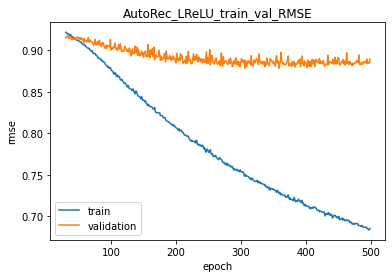

In [ ]:
show_rmse(hist_AutoRec_LReLU, 30, 'AutoRec_LReLU_train_val_RMSE')

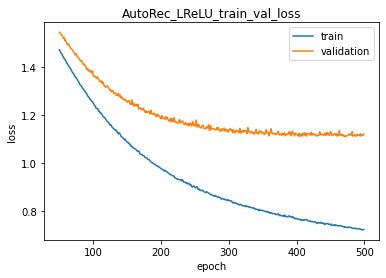

In [ ]:
show_error(hist_AutoRec_LReLU, 50, 'AutoRec_LReLU_train_val_loss')

In [ ]:
AutoRec_LReLU.load_weights(base_path + '/models/' + 'AutoRec_LReLU.h5')
test_AutoRec_LReLU_result = AutoRec_LReLU.evaluate(users_items_matrix_train_average, users_items_matrix_test)

189/189 [==============================] - 0s 2ms/step - loss: 1.1127 - masked_rmse_clip: 0.8858


# **Deep AutoEncoder Collaborative Filtering**

In [ ]:
  def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, side_infor_size=0):
    '''
    Build Deep AE for CF
        INPUT: 
            X: #_user X #_item matrix
            layers: List, each element is the number of neuron for a layer
            reg: L2 regularization parameter
            activation: activation function for all dense layer except the last
            last_activation: activation function for the last dense layer
            dropout: dropout rate
            regularizer_encode: regularizer for encoder
            regularizer_decode: regularizer for decoder
            side_infor_size: size of the one hot encoding side information
        OUTPUT:
            Keras model
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
      
    # Output

    output_layer = Dense(X.shape[1]-side_infor_size, activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model

In [ ]:
# Deep AE parameters
layers = [256, 512, 256]
#layers = [512, 1024, 512] 
#layers = [512, 256, 128, 256, 512] 
#layers = [512, 256, 512]
#layers = [128, 256, 512, 256, 128]
#layers = [512, 512, 512]
dropout = 0.8
# dropout = 0.2
# dropout = 0.4
# dropout = 0.6
# activation = 'sigmoid'
# last_activation = 'linear'
# activation = 'elu'
# last_activation = 'elu' 
activation = 'selu'
last_activation = 'selu' 
# regularizer_encode = 0.002
# regularizer_decode = 0.002
# regularizer_encode = 0.004
# regularizer_decode = 0.004
# regularizer_encode = 0.005
# regularizer_decode = 0.005
# regularizer_encode = 0.0001
# regularizer_decode = 0.0001
# regularizer_encode = 0.01
# regularizer_decode = 0.01
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
# Build model
Deep_AE = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) # learning rate
Deep_AE.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1011968   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015664   
Total params: 2,290,544
Trainable params: 2,290,544
Non-trainable params: 0
_________________________________________________

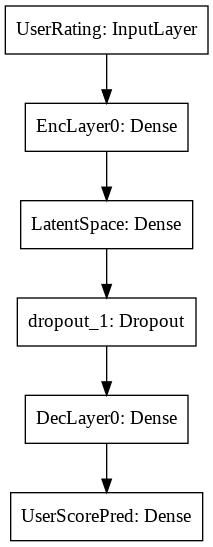

In [ ]:
plot_model(Deep_AE, to_file= base_path + '/models/' + 'Deep_AE.png')

In [ ]:
callbacks = [ ModelCheckpoint(base_path + '/models/' + 'Deep_AE.h5', save_best_only=True)]
hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=500, 
                  batch_size=256,
                  validation_data=(users_items_matrix_train_zero, users_items_matrix_validate), 
                  verbose=2,
                  callbacks = callbacks)

Epoch 1/500
24/24 - 1s - loss: 16.2029 - masked_rmse_clip: 2.8580 - val_loss: 13.7553 - val_masked_rmse_clip: 2.8105
Epoch 2/500
24/24 - 0s - loss: 10.6419 - masked_rmse_clip: 2.4369 - val_loss: 6.2018 - val_masked_rmse_clip: 1.8528
Epoch 3/500
24/24 - 0s - loss: 5.8210 - masked_rmse_clip: 1.7627 - val_loss: 3.7218 - val_masked_rmse_clip: 1.3485
Epoch 4/500
24/24 - 0s - loss: 4.1113 - masked_rmse_clip: 1.4561 - val_loss: 3.0194 - val_masked_rmse_clip: 1.1376
Epoch 5/500
24/24 - 0s - loss: 3.6278 - masked_rmse_clip: 1.3435 - val_loss: 2.8139 - val_masked_rmse_clip: 1.0730
Epoch 6/500
24/24 - 0s - loss: 3.4318 - masked_rmse_clip: 1.3017 - val_loss: 2.7102 - val_masked_rmse_clip: 1.0429
Epoch 7/500
24/24 - 0s - loss: 3.3195 - masked_rmse_clip: 1.2765 - val_loss: 2.6377 - val_masked_rmse_clip: 1.0241
Epoch 8/500
24/24 - 0s - loss: 3.2203 - masked_rmse_clip: 1.2560 - val_loss: 2.5789 - val_masked_rmse_clip: 1.0093
Epoch 9/500
24/24 - 0s - loss: 3.1259 - masked_rmse_clip: 1.2358 - val_loss: 

In [ ]:
# save history as dataframe
hist_Deep_AE_df = pd.DataFrame(hist_Deep_AE.history)

# save training history
pickle.dump(hist_Deep_AE.history, open(base_path + '/models/' + 'hist_Deep_AE_history' + '.pickle', "wb"))

# load training history
hist_Deep_AE_history = open(base_path + '/models/' + 'hist_Deep_AE_history' + '.pickle', "rb")

# show training history
hist_Deep_AE_df

,loss,masked_rmse_clip,val_loss,val_masked_rmse_clip
0,16.202906,2.858029,13.755297,2.810491
1,10.641864,2.436910,6.201828,1.852808
2,5.820964,1.762659,3.721775,1.348542
3,4.111276,1.456085,3.019444,1.137589
4,3.627824,1.343500,2.813875,1.073000
...,...,...,...,...
495,0.826298,0.793736,0.999676,0.854558
496,0.824485,0.792497,0.999885,0.855298
497,0.826025,0.793840,1.001820,0.857024
498,0.826596,0.793872,1.001078,0.856498


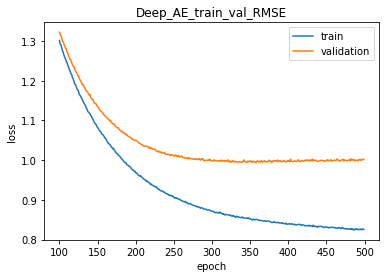

In [ ]:
show_error(hist_Deep_AE, 100, "Deep_AE_train_val_RMSE")

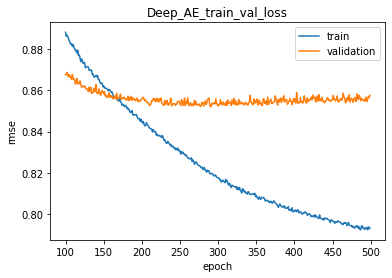

In [ ]:
show_rmse(hist_Deep_AE, 100, "Deep_AE_train_val_loss")

In [ ]:
Deep_AE.load_weights(base_path + '/models/' + 'Deep_AE.h5')
Deep_AE_test_result= Deep_AE.evaluate(users_items_matrix_train_zero, users_items_matrix_test)

189/189 [==============================] - 0s 2ms/step - loss: 0.9957 - masked_rmse_clip: 0.8575


In [ ]:
predict_deep = Deep_AE.predict(users_items_matrix_train_zero)
predict_deep

array([[4.195628 , 4.0277658, 4.116096 , ..., 3.3958285, 4.1437597,
        4.3346767],
       [3.601354 , 3.182079 , 3.5636795, ..., 3.2180507, 3.6338828,
        3.827973 ],
       [3.4143388, 2.981286 , 4.0210047, ..., 2.1960614, 2.805666 ,
        3.128929 ],
       ...,
       [3.7797341, 3.5251722, 3.204414 , ..., 2.977757 , 3.6907463,
        3.2916994],
       [3.9990263, 3.2521043, 2.2823613, ..., 3.8054416, 3.8876095,
        3.7448194],
       [3.3380353, 2.2669008, 1.927886 , ..., 3.5879016, 3.8742123,
        3.4645522]], dtype=float32)

In [ ]:
loss = K.eval(masked_rmse_clip( 
    K.constant((users_items_matrix_train_zero)), 
    K.constant(predict_deep)))
np.mean(loss)

0.77528405

In [ ]:
for layer in Deep_AE.layers: 
  print(layer.get_config())

{'batch_input_shape': (None, 3952), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'UserRating'}
{'name': 'EncLayer0', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'selu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0010000000474974513}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'LatentSpace', 'trainable': True, 'dtype': 'float32', 'units': 512, 'activation': 'selu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0010000000474974513}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constrain

In [ ]:
first_layer_weights = Deep_AE.layers[1].get_weights()[0]

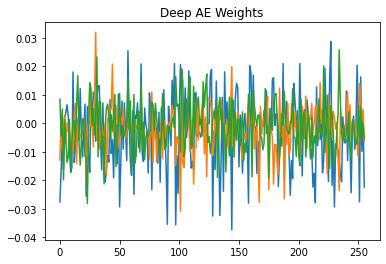

In [ ]:
first_layer_weights = Deep_AE.layers[1].get_weights()[0]
plt.plot(np.arange(0, 256, 1), first_layer_weights[0])
plt.plot(np.arange(0, 256, 1), first_layer_weights[1])
plt.plot(np.arange(0, 256, 1), first_layer_weights[2])
plt.title('Deep AE Weights')
plt.savefig(base_path + '/figures/plt/' + 'Deep AE Weights.jpg',bbox_inches='tight')
plt.show()

**Predict the Ratings**

In [ ]:
Deep_AE.load_weights(base_path + '/models/' + 'Deep_AE.h5')
Deep_AE.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1011968   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015664   
Total params: 2,290,544
Trainable params: 2,290,544
Non-trainable params: 0
_________________________________________________

In [ ]:
TEST_USER = 2000

In [ ]:
# Pick a random test user
users[users['userid'] == TEST_USER]

,userid,gender,age,occupation,zipcode,age_desc,occ_desc,user_emb_id
1999,2000,M,18,4,44685,18-24,college/grad student,1999


In [ ]:
# Function to predict the ratings given User ID and Movie ID
def predict_rating(model, users_items_matrix, user_id, movie_id):
  predicted_ratings = model.predict(users_items_matrix)[user_id][movie_id] 
  # gets predictions of all movies of all users, #6040 users  and 3952 movies
  # get predicted ratings of the movies that this user rated
  return predicted_ratings

In [ ]:
user_ratings = df[df['user_emb_id'] == TEST_USER-1][['user_emb_id', 'movie_emb_id', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(Deep_AE, users_items_matrix_train_zero, x['user_emb_id'], x['movie_emb_id']), axis=1)
user_ratings['rounded_prediction'] = np.round(np.clip(user_ratings['prediction'],1,5))
user_ratings['rating_good'] = np.where(user_ratings['rating'] >= 4, 1, 0)
user_ratings['prediction_good'] = np.where(user_ratings['rounded_prediction'] >= 4, 1, 0)
user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movie_emb_id', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(20)

,user_emb_id,movie_emb_id,rating,prediction,rounded_prediction,rating_good,prediction_good,movieid,title,genre
0,1999,1638,5,3.828896,4.0,1,1,1639,Chasing Amy (1997),Drama|Romance
1,1999,2528,5,3.811894,4.0,1,1,2529,Planet of the Apes (1968),Action|Sci-Fi
2,1999,1135,5,4.457173,4.0,1,1,1136,Monty Python and the Holy Grail (1974),Comedy
3,1999,2320,5,3.915501,4.0,1,1,2321,Pleasantville (1998),Comedy
4,1999,2857,5,4.220160,4.0,1,1,2858,American Beauty (1999),Comedy|Drama
5,1999,2500,5,4.437651,4.0,1,1,2501,October Sky (1999),Drama
6,1999,2803,5,4.419661,4.0,1,1,2804,"Christmas Story, A (1983)",Comedy|Drama
7,1999,1687,5,3.499986,3.0,1,0,1688,Anastasia (1997),Animation|Children's|Musical
8,1999,1652,5,3.904036,4.0,1,1,1653,Gattaca (1997),Drama|Sci-Fi|Thriller
9,1999,526,5,4.668221,5.0,1,1,527,Schindler's List (1993),Drama|War


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(user_ratings['prediction_good'], user_ratings['rating_good'])

0.7040816326530612

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(user_ratings['prediction'], user_ratings['rating'])

0.6989753867952495

**Recommendation**

In [ ]:
recommendations = df[df['movie_emb_id'].isin(user_ratings['movie_emb_id']) == False][['movie_emb_id']].drop_duplicates()
recommendations['prediction'] = recommendations.apply(lambda x: predict_rating(Deep_AE, users_items_matrix_test, TEST_USER-1, x['movie_emb_id']), axis=1)
recommendations['rounded_prediction'] = np.round(np.clip(recommendations['prediction'],1,5))
recommendations.sort_values(by='prediction',
                          ascending=False).merge(movies,
                                                 on='movie_emb_id',
                                                 how='inner',
                                                 suffixes=['_u', '_m']).head(20)

,movie_emb_id,prediction,rounded_prediction,movieid,title,genre
0,857,4.480419,4.0,858,"Godfather, The (1972)",Action|Crime|Drama
1,1171,4.433777,4.0,1172,Cinema Paradiso (1988),Comedy|Drama|Romance
2,1212,4.353731,4.0,1213,GoodFellas (1990),Crime|Drama
3,1249,4.352653,4.0,1250,"Bridge on the River Kwai, The (1957)",Drama|War
4,1275,4.332214,4.0,1276,Cool Hand Luke (1967),Comedy|Drama
5,3467,4.321377,4.0,3468,"Hustler, The (1961)",Drama
6,1222,4.309068,4.0,1223,"Grand Day Out, A (1992)",Animation|Comedy
7,1241,4.267504,4.0,1242,Glory (1989),Action|Drama|War
8,1147,4.251782,4.0,1148,"Wrong Trousers, The (1993)",Animation|Comedy
9,744,4.239780,4.0,745,"Close Shave, A (1995)",Animation|Comedy|Thriller


# **Denoise Models**

# **AutoRec Gaussian Noise**

In [ ]:
## Adding Gaussin noise to input
noise_factor = 0.1 # 0.2 #0.3 #0.4 #0.5
users_items_matrix_train_average_noisy = users_items_matrix_train_average + noise_factor * np.random.normal(size=users_items_matrix_train_zero.shape) 
users_items_matrix_train_zero_noisy = users_items_matrix_train_zero + noise_factor * np.random.normal(size=users_items_matrix_train_zero.shape) 

In [ ]:
users_items_matrix_train_average_noisy = users_items_matrix_train_average_noisy.astype('float64')
users_items_matrix_train_zero_noisy = users_items_matrix_train_zero_noisy.astype('float64')

In [ ]:
AutoRec_Gauss = AutoRec_model(users_items_matrix_train_average_noisy, 0.001, 'elu', 'elu') # needs to rerun AutoRec function

AutoRec_Gauss.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_Gauss.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
LatentSpace (Dense)          (None, 500)               1976500   
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1979952   
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


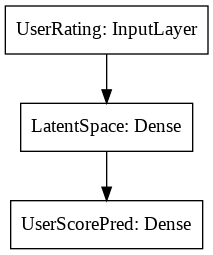

In [ ]:
plot_model(AutoRec_Gauss, to_file= base_path + '/models/' + 'AutoRec_Gauss.png')

In [ ]:
callbacks = [ModelCheckpoint(base_path + '/models/' + 'AutoRec_Gauss.h5', save_best_only=True)]

hist_Autorec_Gauss = AutoRec_Gauss.fit(x=users_items_matrix_train_average_noisy, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=(users_items_matrix_train_average_noisy, users_items_matrix_validate),
                  callbacks=callbacks)

Epoch 1/500
24/24 - 1s - loss: 8.0979 - masked_rmse_clip: 1.8671 - val_loss: 4.2539 - val_masked_rmse_clip: 1.2864
Epoch 2/500
24/24 - 0s - loss: 3.3202 - masked_rmse_clip: 1.1370 - val_loss: 2.8302 - val_masked_rmse_clip: 0.9819
Epoch 3/500
24/24 - 0s - loss: 2.6087 - masked_rmse_clip: 0.9621 - val_loss: 2.5539 - val_masked_rmse_clip: 0.9219
Epoch 4/500
24/24 - 0s - loss: 2.4698 - masked_rmse_clip: 0.9306 - val_loss: 2.4804 - val_masked_rmse_clip: 0.9126
Epoch 5/500
24/24 - 0s - loss: 2.4125 - masked_rmse_clip: 0.9272 - val_loss: 2.4340 - val_masked_rmse_clip: 0.9142
Epoch 6/500
24/24 - 0s - loss: 2.3636 - masked_rmse_clip: 0.9260 - val_loss: 2.3876 - val_masked_rmse_clip: 0.9123
Epoch 7/500
24/24 - 0s - loss: 2.3202 - masked_rmse_clip: 0.9255 - val_loss: 2.3489 - val_masked_rmse_clip: 0.9130
Epoch 8/500
24/24 - 0s - loss: 2.2822 - masked_rmse_clip: 0.9258 - val_loss: 2.3085 - val_masked_rmse_clip: 0.9130
Epoch 9/500
24/24 - 0s - loss: 2.2486 - masked_rmse_clip: 0.9271 - val_loss: 2.2

In [ ]:
# save history as dataframe
hist_Autorec_Gauss_df = pd.DataFrame(hist_Autorec_Gauss.history)

# save training history
pickle.dump(hist_Autorec_Gauss.history, open(base_path + '/models/' + 'hist_Autorec_Gauss_history' + '.pickle', "wb"))

# load training history
hist_Autorec_Gauss_history = open(base_path + '/models/' + 'hist_Autorec_Gauss_history' + '.pickle', "rb")

# show training history
hist_Autorec_Gauss_df

,loss,masked_rmse_clip,val_loss,val_masked_rmse_clip
0,8.097907,1.867059,4.253930,1.286416
1,3.320167,1.136990,2.830151,0.981874
2,2.608651,0.962070,2.553883,0.921905
3,2.469825,0.930604,2.480358,0.912598
4,2.412543,0.927153,2.433973,0.914184
...,...,...,...,...
495,0.800921,0.784945,1.021962,0.873495
496,0.801928,0.785587,1.024013,0.875883
497,0.800099,0.784465,1.025434,0.877061
498,0.799428,0.784182,1.027252,0.877083


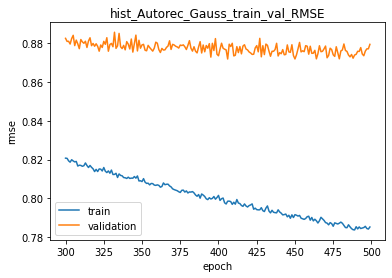

In [ ]:
show_rmse(hist_Autorec_Gauss, 300, "hist_Autorec_Gauss_train_val_RMSE")

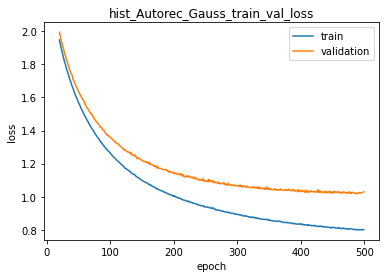

In [ ]:
show_error(hist_Autorec_Gauss, 20, "hist_Autorec_Gauss_train_val_loss")

In [ ]:
AutoRec_Gauss.load_weights(base_path + '/models/' + 'AutoRec_Gauss.h5')
test_result_deep = AutoRec_Gauss.evaluate(users_items_matrix_train_average_noisy, users_items_matrix_test)

189/189 [==============================] - 0s 2ms/step - loss: 1.0206 - masked_rmse_clip: 0.8772


# **Deep AutoEncoders Gaussian Noise**

In [ ]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
# Build model
Deep_AE_denoise = Deep_AE_model(users_items_matrix_train_zero_noisy, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_denoise.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_denoise.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1011968   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015664   
Total params: 2,290,544
Trainable params: 2,290,544
Non-trainable params: 0
________________________________________________

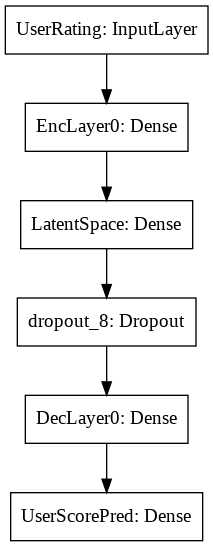

In [ ]:
plot_model(Deep_AE_denoise, to_file=base_path + '/models/' + 'deep_AE_denoise.png')

In [ ]:
callbacks = [ModelCheckpoint(base_path + '/models/' + 'DeepAE_denoise.h5', save_best_only=True)]
hist_Deep_AE_denoise = Deep_AE_denoise.fit(x=users_items_matrix_train_zero_noisy, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  validation_data=(users_items_matrix_train_zero_noisy, users_items_matrix_validate), 
                  verbose=2,
                  callbacks=callbacks)

Epoch 1/500
24/24 - 1s - loss: 16.2173 - masked_rmse_clip: 2.8545 - val_loss: 13.9105 - val_masked_rmse_clip: 2.8146
Epoch 2/500
24/24 - 0s - loss: 10.9117 - masked_rmse_clip: 2.4675 - val_loss: 6.5596 - val_masked_rmse_clip: 1.9303
Epoch 3/500
24/24 - 0s - loss: 6.1836 - masked_rmse_clip: 1.8147 - val_loss: 3.9562 - val_masked_rmse_clip: 1.4063
Epoch 4/500
24/24 - 0s - loss: 4.2778 - masked_rmse_clip: 1.4862 - val_loss: 3.1169 - val_masked_rmse_clip: 1.1574
Epoch 5/500
24/24 - 0s - loss: 3.7448 - masked_rmse_clip: 1.3638 - val_loss: 2.8802 - val_masked_rmse_clip: 1.0812
Epoch 6/500
24/24 - 0s - loss: 3.5055 - masked_rmse_clip: 1.3065 - val_loss: 2.7696 - val_masked_rmse_clip: 1.0479
Epoch 7/500
24/24 - 0s - loss: 3.3816 - masked_rmse_clip: 1.2809 - val_loss: 2.6930 - val_masked_rmse_clip: 1.0255
Epoch 8/500
24/24 - 0s - loss: 3.2829 - masked_rmse_clip: 1.2581 - val_loss: 2.6392 - val_masked_rmse_clip: 1.0118
Epoch 9/500
24/24 - 0s - loss: 3.1971 - masked_rmse_clip: 1.2383 - val_loss: 

In [ ]:
# save history as dataframe
hist_Deep_AE_denoise_df = pd.DataFrame(hist_Deep_AE_denoise.history)

# save training history
pickle.dump(hist_Deep_AE_denoise.history, open(base_path + '/models/' + 'hist_Deep_AE_denoise_history' + '.pickle', "wb"))

# load training history
hist_Deep_AE_denoise_history = open(base_path + '/models/' + 'hist_Deep_AE_denoise_history' + '.pickle', "rb")

# show training history
hist_Deep_AE_denoise_df

,loss,masked_rmse_clip,val_loss,val_masked_rmse_clip
0,16.217348,2.854460,13.910464,2.814608
1,10.911664,2.467483,6.559568,1.930349
2,6.183596,1.814654,3.956174,1.406302
3,4.277763,1.486205,3.116897,1.157384
4,3.744771,1.363814,2.880228,1.081249
...,...,...,...,...
495,0.811536,0.779683,1.013475,0.858081
496,0.812944,0.780486,1.014256,0.858821
497,0.813123,0.780580,1.012332,0.856938
498,0.812843,0.780444,1.013651,0.857816


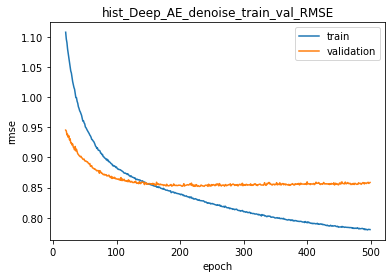

In [ ]:
show_rmse(hist_Deep_AE_denoise, 20, "hist_Deep_AE_denoise_train_val_RMSE")

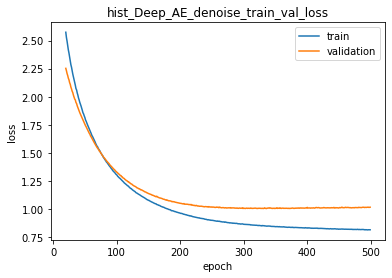

In [ ]:
show_error(hist_Deep_AE_denoise, 20, "hist_Deep_AE_denoise_train_val_loss")

In [ ]:
Deep_AE_denoise.load_weights(base_path + '/models/' + 'DeepAE_denoise.h5')
test_result_deep = Deep_AE_denoise.evaluate(users_items_matrix_train_zero_noisy, users_items_matrix_test)

189/189 [==============================] - 0s 2ms/step - loss: 0.9994 - masked_rmse_clip: 0.8568


In [ ]:
predict_deep = Deep_AE_denoise.predict(users_items_matrix_train_zero_noisy)
loss = K.eval(masked_rmse_clip( 
    K.constant((users_items_matrix_train_zero)), 
    K.constant(predict_deep)))
np.mean(loss)

0.7726955

# **Deep AutoEncoders Dropout Noise**

In [ ]:
  def Deep_AE_DropNoise_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, noise):
    '''
    Build Deep AE for CF
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Dropout Noise
    x = Dropout(rate = noise)(x)
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
    # Output

    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model

In [ ]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001
dropN = 0.1

In [ ]:
# Build model
Deep_AE_denoise_dropN = Deep_AE_DropNoise_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, dropN)
Deep_AE_denoise_dropN.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_denoise_dropN.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3952)              0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1011968   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015

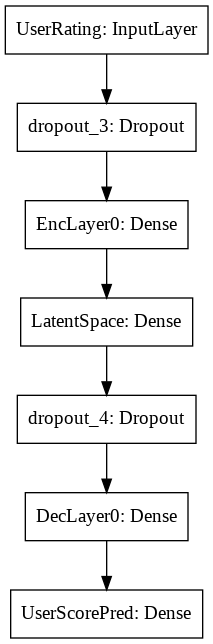

In [ ]:
plot_model(Deep_AE_denoise_dropN , to_file=base_path + '/models/' + 'Deep_AE_denoise_dropN.png')

In [ ]:
callbacks = [ModelCheckpoint(base_path + '/models/' + 'Deep_AE_denoise_dropN.h5', save_best_only=True)]
hist_Deep_AE_denoise_dropN = Deep_AE_denoise_dropN.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  validation_data=(users_items_matrix_train_zero, users_items_matrix_validate), 
                  verbose=2,
                  callbacks=callbacks)

Epoch 1/500
24/24 - 1s - loss: 16.4006 - masked_rmse_clip: 2.8633 - val_loss: 14.2071 - val_masked_rmse_clip: 2.8312
Epoch 2/500
24/24 - 0s - loss: 11.1890 - masked_rmse_clip: 2.5069 - val_loss: 6.5528 - val_masked_rmse_clip: 1.9310
Epoch 3/500
24/24 - 0s - loss: 6.1247 - masked_rmse_clip: 1.7994 - val_loss: 3.8516 - val_masked_rmse_clip: 1.3827
Epoch 4/500
24/24 - 0s - loss: 4.2238 - masked_rmse_clip: 1.4849 - val_loss: 3.0517 - val_masked_rmse_clip: 1.1462
Epoch 5/500
24/24 - 0s - loss: 3.6716 - masked_rmse_clip: 1.3567 - val_loss: 2.8274 - val_masked_rmse_clip: 1.0761
Epoch 6/500
24/24 - 0s - loss: 3.4658 - masked_rmse_clip: 1.3100 - val_loss: 2.7161 - val_masked_rmse_clip: 1.0436
Epoch 7/500
24/24 - 0s - loss: 3.3334 - masked_rmse_clip: 1.2799 - val_loss: 2.6423 - val_masked_rmse_clip: 1.0239
Epoch 8/500
24/24 - 0s - loss: 3.2229 - masked_rmse_clip: 1.2564 - val_loss: 2.5866 - val_masked_rmse_clip: 1.0108
Epoch 9/500
24/24 - 0s - loss: 3.1423 - masked_rmse_clip: 1.2399 - val_loss: 

In [ ]:
# save history as dataframe
hist_Deep_AE_denoise_dropN_df = pd.DataFrame(hist_Deep_AE_denoise_dropN.history)

# save training history
pickle.dump(hist_Deep_AE_denoise_dropN.history, open(base_path + '/models/' + 'hist_Deep_AE_denoise_dropN_history' + '.pickle', "wb"))

# load training history
hist_Deep_AE_denoise_dropN_history = open(base_path + '/models/' + 'hist_Deep_AE_denoise_dropN_history' + '.pickle', "rb")

# show training history
hist_Deep_AE_denoise_dropN_df

,loss,masked_rmse_clip,val_loss,val_masked_rmse_clip
0,16.400572,2.863256,14.207099,2.831214
1,11.188963,2.506938,6.552791,1.930952
2,6.124683,1.799354,3.851599,1.382654
3,4.223796,1.484851,3.051663,1.146221
4,3.671629,1.356693,2.827402,1.076057
...,...,...,...,...
495,0.843365,0.812629,0.977215,0.851811
496,0.843836,0.812635,0.977493,0.851657
497,0.842625,0.812192,0.976928,0.851635
498,0.844594,0.813314,0.979023,0.852924


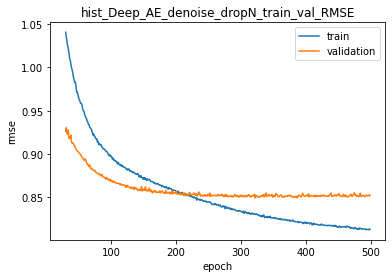

In [ ]:
show_rmse(hist_Deep_AE_denoise_dropN, 30, "hist_Deep_AE_denoise_dropN_train_val_RMSE")

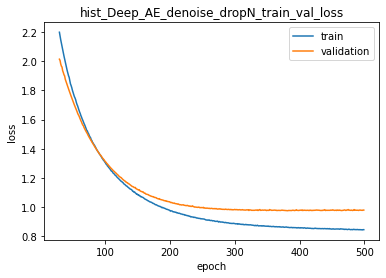

In [ ]:
show_error(hist_Deep_AE_denoise_dropN, 30, "hist_Deep_AE_denoise_dropN_train_val_loss")

In [ ]:
Deep_AE_denoise_dropN.load_weights(base_path + '/models/' + 'Deep_AE_denoise_dropN.h5')
test_result_deep = Deep_AE_denoise_dropN.evaluate(users_items_matrix_train_zero, users_items_matrix_test)

189/189 [==============================] - 0s 2ms/step - loss: 0.9768 - masked_rmse_clip: 0.8547


# **Hybrid Models**

**Preprocessing the side information**

In [ ]:
user_df = pd.read_csv(base_path + '/data/users.csv',sep='\t', encoding='latin-1', 
                      usecols=['user_id', 'gender', 'age', 'occupation'])
user_df.head(5)

,user_id,gender,age,occupation
0,1,F,1,10
1,2,M,56,16
2,3,M,25,15
3,4,M,45,7
4,5,M,25,20


In [ ]:
# Transform side information to onehot encoding
user_df['age'] = preprocessing.LabelEncoder().fit(user_df['age']).transform(user_df['age'])
user_df['gender'] = preprocessing.LabelEncoder().fit(user_df['gender']).transform(user_df['gender'])
onehot_df = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False).fit(user_df[['gender', 'age', 'occupation']]).transform(user_df[['gender', 'age', 'occupation']])

In [ ]:
onehot_df.shape

(6040, 30)

**Concatenate content to input keep output the same**

In [ ]:
#Concatenate the one hot encoding side information to the rating matrix
user_items_user_info = np.concatenate((users_items_matrix_train_zero, onehot_df), axis=1)

In [ ]:
user_items_user_info.shape

(6040, 3982)

In [ ]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
# Build model
Deep_AE_concate = Deep_AE_model(user_items_user_info, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, 30)
Deep_AE_concate.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_concate.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3982)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1019648   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015664   
Total params: 2,298,224
Trainable params: 2,298,224
Non-trainable params: 0
________________________________________________

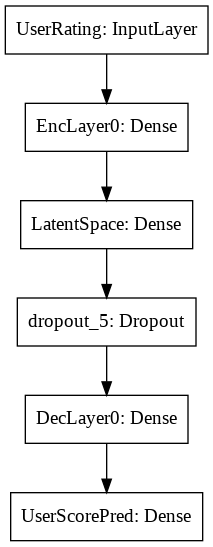

In [ ]:
plot_model(Deep_AE_concate, to_file=base_path + '/models/' +'Deep_AE_concate.png')

In [ ]:
callbacks = [ModelCheckpoint(base_path + '/models/' + 'Deep_AE_concate.h5', save_best_only=True)]
hist_Deep_AE_concate = Deep_AE_concate.fit(x=user_items_user_info, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  validation_data=(user_items_user_info, users_items_matrix_validate), 
                  verbose=2,
                  callbacks=callbacks)

Epoch 1/500
24/24 - 1s - loss: 16.0454 - masked_rmse_clip: 2.8514 - val_loss: 13.3383 - val_masked_rmse_clip: 2.7871
Epoch 2/500
24/24 - 0s - loss: 10.3654 - masked_rmse_clip: 2.4012 - val_loss: 6.0586 - val_masked_rmse_clip: 1.8313
Epoch 3/500
24/24 - 0s - loss: 5.6819 - masked_rmse_clip: 1.7430 - val_loss: 3.6725 - val_masked_rmse_clip: 1.3302
Epoch 4/500
24/24 - 0s - loss: 4.0685 - masked_rmse_clip: 1.4426 - val_loss: 2.9774 - val_masked_rmse_clip: 1.1236
Epoch 5/500
24/24 - 0s - loss: 3.5810 - masked_rmse_clip: 1.3355 - val_loss: 2.7737 - val_masked_rmse_clip: 1.0578
Epoch 6/500
24/24 - 0s - loss: 3.3800 - masked_rmse_clip: 1.2871 - val_loss: 2.6762 - val_masked_rmse_clip: 1.0299
Epoch 7/500
24/24 - 0s - loss: 3.2884 - masked_rmse_clip: 1.2701 - val_loss: 2.6093 - val_masked_rmse_clip: 1.0125
Epoch 8/500
24/24 - 0s - loss: 3.1713 - masked_rmse_clip: 1.2431 - val_loss: 2.5601 - val_masked_rmse_clip: 1.0020
Epoch 9/500
24/24 - 0s - loss: 3.0935 - masked_rmse_clip: 1.2260 - val_loss: 

In [ ]:
# save history as dataframe
hist_Deep_AE_concate_df = pd.DataFrame(hist_Deep_AE_concate.history)

# save training history
pickle.dump(hist_Deep_AE_concate.history, open(base_path + '/models/' + 'hist_Deep_AE_concate_history' + '.pickle', "wb"))

# load training history
hist_Deep_AE_concate_history = open(base_path + '/models/' + 'hist_Deep_AE_concate_history' + '.pickle', "rb")

# show training history
hist_Deep_AE_concate_df

,loss,masked_rmse_clip,val_loss,val_masked_rmse_clip
0,16.045416,2.851441,13.338293,2.787104
1,10.365376,2.401247,6.058595,1.831292
2,5.681892,1.743004,3.672471,1.330244
3,4.068494,1.442620,2.977433,1.123606
4,3.580964,1.335508,2.773681,1.057755
...,...,...,...,...
495,0.822011,0.791047,0.998584,0.855088
496,0.822057,0.791186,0.997819,0.853988
497,0.820874,0.790379,0.998754,0.854857
498,0.821345,0.790652,1.001761,0.857306


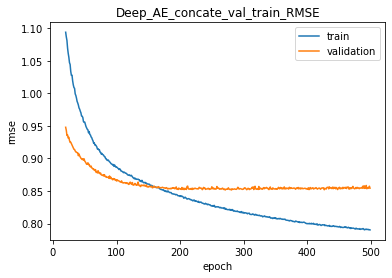

In [ ]:
show_rmse(hist_Deep_AE_concate, 20, "Deep_AE_concate_val_train_RMSE")

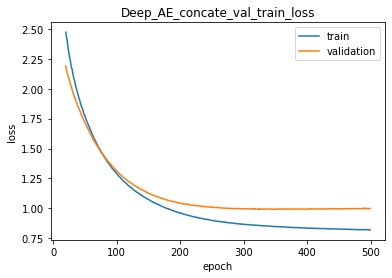

In [ ]:
show_error(hist_Deep_AE_concate, 20, "Deep_AE_concate_val_train_loss")

In [ ]:
Deep_AE_concate.load_weights(base_path + '/models/' + 'Deep_AE_concate.h5')
test_result_deep = Deep_AE_concate.evaluate(user_items_user_info, users_items_matrix_test)

189/189 [==============================] - 0s 2ms/step - loss: 0.9930 - masked_rmse_clip: 0.8569


# **Groups Specific Predictions/ Recommendations**

**Preprocessing and Concatenating Additonal Features** 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1cf57cd050>,
      dtype=object)

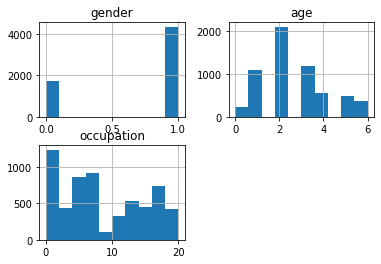

In [ ]:
user_df.hist(column=['gender', 'age', 'occupation'])

In [ ]:
for feature in ['gender', 'age', 'occupation']:
  print(feature)
  print(user_df[feature].unique())

gender
[0 1]
age
[0 6 2 4 5 3 1]
occupation
[10 16 15  7 20  9  1 12 17  0  3 14  4 11  8 19  2 18  5 13  6]


In [ ]:
onehot_df

array([[1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
onehot_df

In [ ]:
#Concatenate the one hot encoding side information to the rating matrix
user_items_user_validate_info = np.concatenate((users_items_matrix_validate, onehot_df), axis=1)

# **Male, Age Group 2**

In [ ]:
train_male_two = user_items_user_info[(user_items_user_info[:, 3953]==1) & (user_items_user_info[:, 3956]==1)]
validate_male_two = user_items_user_validate_info[(user_items_user_validate_info[:, 3953]==1) & (user_items_user_validate_info[:, 3956]==1)]

In [ ]:
train_male_two.shape

(1538, 3982)

In [ ]:
train_male_two[:, :3952].shape

(1538, 3952)

In [ ]:
validate_male_two.shape

(1538, 3982)

In [ ]:
 validate_male_two[:, :3952].shape

(1538, 3952)

In [ ]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
# Build model
Deep_AE_concate_male_two = Deep_AE_model(train_male_two[:, :3952], layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_concate_male_two.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_concate_male_two.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1011968   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015664   
Total params: 2,290,544
Trainable params: 2,290,544
Non-trainable params: 0
___________________________________________________

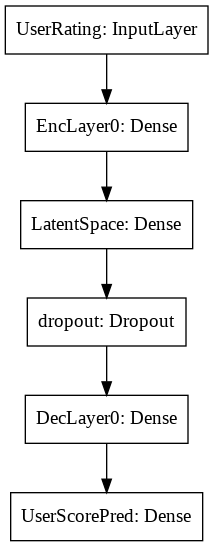

In [ ]:
plot_model(Deep_AE_concate_male_two, to_file=base_path + '/models/' + 'Deep_AE_concate_male_two.png')

In [ ]:
callbacks = [ModelCheckpoint(base_path + '/models/' + 'Deep_AE_concate_male_two.h5', save_best_only=True)]
hist_Deep_AE_concate_male_two = Deep_AE_concate_male_two.fit(x=train_male_two[:, :3952], y=train_male_two[:, :3952],
                  epochs=500,
                  batch_size=256,
                  validation_data=(train_male_two[:, :3952], validate_male_two[:, :3952]), 
                  verbose=2,
                  callbacks=callbacks)

Epoch 1/500
7/7 - 3s - loss: 16.8490 - masked_rmse_clip: 2.8396 - val_loss: 16.3067 - val_masked_rmse_clip: 2.8512
Epoch 2/500
7/7 - 0s - loss: 16.1946 - masked_rmse_clip: 2.8276 - val_loss: 15.6059 - val_masked_rmse_clip: 2.8458
Epoch 3/500
7/7 - 0s - loss: 15.4041 - masked_rmse_clip: 2.8036 - val_loss: 14.5611 - val_masked_rmse_clip: 2.8243
Epoch 4/500
7/7 - 0s - loss: 14.2756 - masked_rmse_clip: 2.7533 - val_loss: 13.0597 - val_masked_rmse_clip: 2.7571
Epoch 5/500
7/7 - 0s - loss: 12.7781 - masked_rmse_clip: 2.6577 - val_loss: 11.1288 - val_masked_rmse_clip: 2.6067
Epoch 6/500
7/7 - 0s - loss: 11.0230 - masked_rmse_clip: 2.5058 - val_loss: 9.1415 - val_masked_rmse_clip: 2.3790
Epoch 7/500
7/7 - 0s - loss: 9.4397 - masked_rmse_clip: 2.3182 - val_loss: 7.5526 - val_masked_rmse_clip: 2.1355
Epoch 8/500
7/7 - 0s - loss: 8.2441 - masked_rmse_clip: 2.1494 - val_loss: 6.4439 - val_masked_rmse_clip: 1.9422
Epoch 9/500
7/7 - 0s - loss: 7.1772 - masked_rmse_clip: 1.9961 - val_loss: 5.5944 - v

In [ ]:
# save history as dataframe
hist_Deep_AE_concate_male_two_df = pd.DataFrame(hist_Deep_AE_concate_male_two.history)

# save training history
pickle.dump(hist_Deep_AE_concate_male_two.history, open(base_path + '/models/' + 'hist_Deep_AE_concate_male_two_history' + '.pickle', "wb"))

# load training history
hist_Deep_AE_concate_male_two_history = open(base_path + '/models/' + 'hist_Deep_AE_concate_male_two_history' + '.pickle', "rb")

# show training history
hist_Deep_AE_concate_male_two_df

,loss,masked_rmse_clip,val_loss,val_masked_rmse_clip
0,16.848984,2.839574,16.306698,2.851229
1,16.194567,2.827621,15.605879,2.845845
2,15.404059,2.803577,14.561144,2.824297
3,14.275636,2.753299,13.059684,2.757052
4,12.778112,2.657727,11.128789,2.606658
...,...,...,...,...
495,1.483454,0.861913,1.598988,0.891800
496,1.481792,0.860716,1.595499,0.890140
497,1.479124,0.860715,1.597624,0.893268
498,1.474713,0.858897,1.593974,0.891611


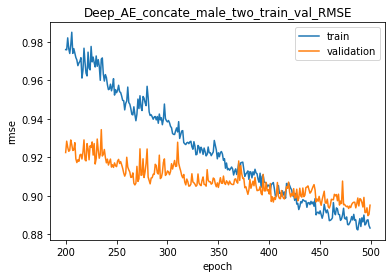

In [ ]:
show_rmse(hist_Deep_AE_concate_male_two, 200, "Deep_AE_concate_male_two_train_val_RMSE")

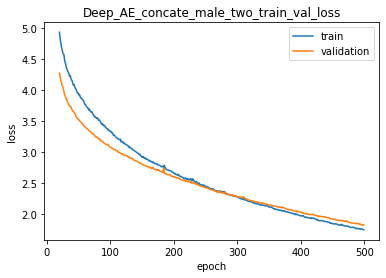

In [ ]:
show_error(hist_Deep_AE_concate_male_two, 20, "Deep_AE_concate_male_two_train_val_loss")

In [ ]:
print(user_items_user_info.shape)
print(users_items_matrix_test.shape)

(6040, 3982)
(6040, 3952)


In [ ]:
#Concatenate the one hot encoding side information to the rating matrix
users_items_matrix_test_info = np.concatenate((users_items_matrix_test, onehot_df), axis=1)
users_items_matrix_test_info.shape

(6040, 3982)

In [ ]:
y_test_male_two = users_items_matrix_test_info[(users_items_matrix_test_info[:, 3953]==1) & (users_items_matrix_test_info[:, 3956]==1)]
y_test_male_two.shape

(1538, 3982)

In [ ]:
users_items_matrix_train_zero_info = np.concatenate((users_items_matrix_train_zero, onehot_df), axis=1)
users_items_matrix_train_zero_info.shape

(6040, 3982)

In [ ]:
x_test_male_two = users_items_matrix_train_zero_info[(users_items_matrix_train_zero_info[:, 3953]==1) & (users_items_matrix_train_zero_info[:, 3956]==1)]
x_test_male_two.shape

(1538, 3982)

In [ ]:
Deep_AE_concate_male_two.load_weights(base_path + '/models/' + 'Deep_AE_concate_male_two.h5')
Deep_AE_concate_male_two.evaluate(x_test_male_two[:, :3952], y_test_male_two[:, :3952])

49/49 [==============================] - 0s 2ms/step - loss: 1.5709 - masked_rmse_clip: 0.8812


[1.5709246397018433, 0.8811817765235901]

**Predict the Ratings**

In [ ]:
Deep_AE_concate_male_two.load_weights(base_path + '/models/' + 'Deep_AE_concate_male_two.h5')
Deep_AE_concate_male_two.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1011968   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015664   
Total params: 2,290,544
Trainable params: 2,290,544
Non-trainable params: 0
___________________________________________________

In [ ]:
TEST_USER = 2000

In [ ]:
# Pick a random test user
users[users['userid'] == TEST_USER]

,userid,gender,age,occupation,zipcode,age_desc,occ_desc,user_emb_id
1999,2000,M,18,4,44685,18-24,college/grad student,1999


In [ ]:
# Function to predict the ratings given User ID and Movie ID
def predict_rating(model, users_items_matrix, user_id, movie_id):
  predicted_ratings = model.predict(users_items_matrix)[user_id][movie_id] 
  # gets predictions of all movies of all users, #6040 users  and 3952 movies
  # get predicted ratings of the movies that this user rated
  return predicted_ratings

In [ ]:
user_ratings_male_two = df[df['user_emb_id'] == TEST_USER-1][['user_emb_id', 'movie_emb_id', 'rating']]
user_ratings_male_two['prediction'] = user_ratings_male_two.apply(lambda x: predict_rating(Deep_AE_concate_male_two, users_items_matrix_train_zero, x['user_emb_id'], x['movie_emb_id']), axis=1)
user_ratings_male_two['rounded_prediction'] = np.round(np.clip(user_ratings_male_two['prediction'],1,5))
user_ratings_male_two['rating_good'] = np.where(user_ratings_male_two['rating'] >= 4, 1, 0)
user_ratings_male_two['prediction_good'] = np.where(user_ratings_male_two['rounded_prediction'] >= 4, 1, 0)
user_ratings_male_two.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movie_emb_id', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(20)

,user_emb_id,movie_emb_id,rating,prediction,rounded_prediction,rating_good,prediction_good,movieid,title,genre
0,1999,1638,5,3.511441,4.0,1,1,1639,Chasing Amy (1997),Drama|Romance
1,1999,2528,5,3.450643,3.0,1,0,2529,Planet of the Apes (1968),Action|Sci-Fi
2,1999,1135,5,4.121513,4.0,1,1,1136,Monty Python and the Holy Grail (1974),Comedy
3,1999,2320,5,3.375851,3.0,1,0,2321,Pleasantville (1998),Comedy
4,1999,2857,5,4.038535,4.0,1,1,2858,American Beauty (1999),Comedy|Drama
5,1999,2500,5,4.124715,4.0,1,1,2501,October Sky (1999),Drama
6,1999,2803,5,4.121089,4.0,1,1,2804,"Christmas Story, A (1983)",Comedy|Drama
7,1999,1687,5,2.789663,3.0,1,0,1688,Anastasia (1997),Animation|Children's|Musical
8,1999,1652,5,3.475725,3.0,1,0,1653,Gattaca (1997),Drama|Sci-Fi|Thriller
9,1999,526,5,4.525002,5.0,1,1,527,Schindler's List (1993),Drama|War


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(user_ratings_male_two['prediction_good'], user_ratings_male_two['rating_good'])

0.6326530612244898

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(user_ratings_male_two['prediction'], user_ratings_male_two['rating'])

0.8296973792153521

**Recommendation**

In [63]:
recommendations_male_two = df[df['movie_emb_id'].isin(user_ratings_male_two['movie_emb_id']) == False][['movie_emb_id']].drop_duplicates()
recommendations_male_two['prediction'] = recommendations_male_two.apply(lambda x: predict_rating(Deep_AE_concate_male_two, users_items_matrix_train_zero, TEST_USER-1, x['movie_emb_id']), axis=1)
recommendations_male_two['rounded_prediction'] = np.round(np.clip(recommendations_male_two['prediction'],1,5))
recommendations_male_two.sort_values(by='prediction',
                          ascending=False).merge(movies,
                                                 on='movie_emb_id',
                                                 how='inner',
                                                 suffixes=['_u', '_m']).head(20)

,movie_emb_id,prediction,rounded_prediction,movieid,title,genre
0,3338,5.961835,5.0,3339,Cross of Iron (1977),War
1,1116,5.784819,5.0,1117,"Eighth Day, The (Le Huitième jour ) (1996)",Drama
2,2847,4.919725,5.0,2848,Othello (1952),Drama
3,1361,4.862291,5.0,1362,"Garden of Finzi-Contini, The (Giardino dei Fin...",Drama
4,1143,4.642789,5.0,1144,"Line King: Al Hirschfeld, The (1996)",Documentary
5,3935,4.630469,5.0,3936,"Phantom of the Opera, The (1943)",Drama|Thriller
6,3001,4.598530,5.0,3002,My Best Fiend (Mein liebster Feind) (1999),Documentary
7,1244,4.577713,5.0,1245,Miller's Crossing (1990),Drama
8,3639,4.546223,5.0,3640,"King in New York, A (1957)",Comedy|Drama
9,2730,4.534784,5.0,2731,"400 Blows, The (Les Quatre cents coups) (1959)",Drama


# **Age Group 2**

In [64]:
user_items_user_info[:,3956]

array([0., 0., 1., ..., 0., 0., 1.])

In [65]:
train_age2 = user_items_user_info[ (user_items_user_info[:, 3956]==1)]
validate_age2 = user_items_user_validate_info[(user_items_user_validate_info[:, 3956]==1)]
# 3955 is 1103
# 3956 is 2096
# 3957 is 1193

In [66]:
train_age2.shape

(2096, 3982)

In [67]:
train_age2[:, :3952].shape

(2096, 3952)

In [68]:
validate_age2.shape

(2096, 3982)

In [69]:
validate_age2[:, :3952].shape

(2096, 3952)

In [70]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [71]:
# Build model
Deep_AE_concate_age2 = Deep_AE_model(train_age2[:, :3952], layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_concate_age2.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_concate_age2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1011968   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015664   
Total params: 2,290,544
Trainable params: 2,290,544
Non-trainable params: 0
_________________________________________________

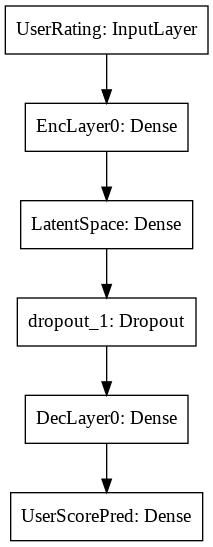

In [72]:
plot_model(Deep_AE_concate_age2, to_file=base_path + '/models/' + 'Deep_AE_concate_age2.png')

In [73]:
callbacks = [ModelCheckpoint(base_path + '/models/' + 'Deep_AE_concate_age2.h5', save_best_only=True)]
hist_Deep_AE_concate_age2 = Deep_AE_concate_age2.fit(x=train_age2[:, :3952], y=train_age2[:, :3952],
                  epochs=500,
                  batch_size=256,
                  validation_data=(train_age2[:, :3952], validate_age2[:, :3952]), 
                  verbose=2,
                  callbacks=callbacks)

Epoch 1/500
9/9 - 1s - loss: 16.8005 - masked_rmse_clip: 2.8501 - val_loss: 16.1177 - val_masked_rmse_clip: 2.8542
Epoch 2/500
9/9 - 0s - loss: 15.8308 - masked_rmse_clip: 2.8293 - val_loss: 14.8112 - val_masked_rmse_clip: 2.8331
Epoch 3/500
9/9 - 0s - loss: 14.1808 - masked_rmse_clip: 2.7563 - val_loss: 12.3761 - val_masked_rmse_clip: 2.7068
Epoch 4/500
9/9 - 0s - loss: 11.6180 - masked_rmse_clip: 2.5677 - val_loss: 9.1022 - val_masked_rmse_clip: 2.3661
Epoch 5/500
9/9 - 0s - loss: 9.0721 - masked_rmse_clip: 2.2549 - val_loss: 6.7494 - val_masked_rmse_clip: 1.9701
Epoch 6/500
9/9 - 0s - loss: 7.2709 - masked_rmse_clip: 1.9729 - val_loss: 5.3260 - val_masked_rmse_clip: 1.7082
Epoch 7/500
9/9 - 0s - loss: 5.9155 - masked_rmse_clip: 1.7884 - val_loss: 4.4145 - val_masked_rmse_clip: 1.5236
Epoch 8/500
9/9 - 0s - loss: 4.9690 - masked_rmse_clip: 1.6476 - val_loss: 3.8249 - val_masked_rmse_clip: 1.3756
Epoch 9/500
9/9 - 0s - loss: 4.4105 - masked_rmse_clip: 1.5252 - val_loss: 3.4350 - val_m

In [74]:
# save history as dataframe
hist_Deep_AE_concate_age2_df = pd.DataFrame(hist_Deep_AE_concate_age2.history)

# save training history
pickle.dump(hist_Deep_AE_concate_age2.history, open(base_path + '/models/' + 'hist_Deep_AE_concate_age2_history' + '.pickle', "wb"))

# load training history
hist_Deep_AE_concate_age2_history = open(base_path + '/models/' + 'hist_Deep_AE_concate_age2_history' + '.pickle', "rb")

# show training history
hist_Deep_AE_concate_age2_df

,loss,masked_rmse_clip,val_loss,val_masked_rmse_clip
0,16.800524,2.850105,16.117737,2.854195
1,15.830764,2.829285,14.811192,2.833136
2,14.180779,2.756270,12.376136,2.706799
3,11.618015,2.567657,9.102201,2.366112
4,9.072081,2.254936,6.749373,1.970121
...,...,...,...,...
495,0.873331,0.736681,1.189403,0.888368
496,0.873385,0.737600,1.185613,0.886034
497,0.876022,0.739076,1.185233,0.886084
498,0.873205,0.738153,1.188581,0.888447


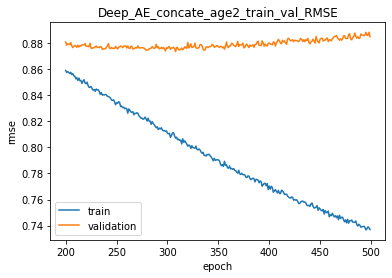

In [75]:
show_rmse(hist_Deep_AE_concate_age2, 200, "Deep_AE_concate_age2_train_val_RMSE")

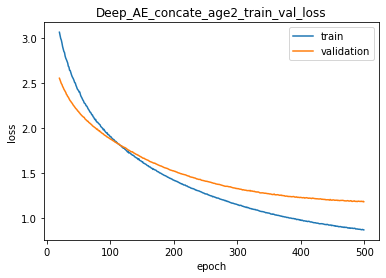

In [76]:
show_error(hist_Deep_AE_concate_age2, 20, "Deep_AE_concate_age2_train_val_loss")

In [77]:
print(user_items_user_info.shape)
print(users_items_matrix_test.shape)

(6040, 3982)
(6040, 3952)


In [78]:
#Concatenate the one hot encoding side information to the rating matrix
users_items_matrix_test_info = np.concatenate((users_items_matrix_test, onehot_df), axis=1)
users_items_matrix_test_info.shape

(6040, 3982)

In [79]:
y_test_age2 = users_items_matrix_test_info[(users_items_matrix_test_info[:, 3956]==1)]
y_test_age2.shape

(2096, 3982)

In [80]:
users_items_matrix_train_zero_info = np.concatenate((users_items_matrix_train_zero, onehot_df), axis=1)
users_items_matrix_train_zero_info.shape

(6040, 3982)

In [81]:
x_test_age2 = users_items_matrix_train_zero_info[(users_items_matrix_train_zero_info[:, 3956]==1)]
x_test_age2.shape

(2096, 3982)

In [82]:
Deep_AE_concate_age2.load_weights(base_path + '/models/' + 'Deep_AE_concate_age2.h5')
Deep_AE_concate_age2.evaluate(x_test_age2[:, :3952], y_test_age2[:, :3952])

66/66 [==============================] - 0s 2ms/step - loss: 1.1482 - masked_rmse_clip: 0.8736


[1.1481925249099731, 0.8735504150390625]

**Predict the Ratings**

In [83]:
Deep_AE_concate_age2.load_weights(base_path + '/models/' + 'Deep_AE_concate_age2.h5')
Deep_AE_concate_age2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3952)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1011968   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015664   
Total params: 2,290,544
Trainable params: 2,290,544
Non-trainable params: 0
_________________________________________________

In [84]:
TEST_USER = 2000

In [85]:
# Pick a random test user
users[users['userid'] == TEST_USER]

,userid,gender,age,occupation,zipcode,age_desc,occ_desc,user_emb_id
1999,2000,M,18,4,44685,18-24,college/grad student,1999


In [86]:
# Function to predict the ratings given User ID and Movie ID
def predict_rating(model, users_items_matrix, user_id, movie_id):
  predicted_ratings = model.predict(users_items_matrix)[user_id][movie_id] 
  # gets predictions of all movies of all users, #6040 users  and 3952 movies
  # get predicted ratings of the movies that this user rated
  return predicted_ratings

In [87]:
user_ratings_age2 = df[df['user_emb_id'] == TEST_USER-1][['user_emb_id', 'movie_emb_id', 'rating']]
user_ratings_age2['prediction'] = user_ratings_age2.apply(lambda x: predict_rating(Deep_AE_concate_age2, users_items_matrix_train_zero, x['user_emb_id'], x['movie_emb_id']), axis=1)
user_ratings_age2['rounded_prediction'] = np.round(np.clip(user_ratings_age2['prediction'],1,5))
user_ratings_age2['rating_good'] = np.where(user_ratings_age2['rating'] >= 4, 1, 0)
user_ratings_age2['prediction_good'] = np.where(user_ratings_age2['rounded_prediction'] >= 4, 1, 0)
user_ratings_age2.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movie_emb_id', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(20)

,user_emb_id,movie_emb_id,rating,prediction,rounded_prediction,rating_good,prediction_good,movieid,title,genre
0,1999,1638,5,3.975507,4.0,1,1,1639,Chasing Amy (1997),Drama|Romance
1,1999,2528,5,3.757034,4.0,1,1,2529,Planet of the Apes (1968),Action|Sci-Fi
2,1999,1135,5,4.038831,4.0,1,1,1136,Monty Python and the Holy Grail (1974),Comedy
3,1999,2320,5,3.335797,3.0,1,0,2321,Pleasantville (1998),Comedy
4,1999,2857,5,3.977855,4.0,1,1,2858,American Beauty (1999),Comedy|Drama
5,1999,2500,5,4.101748,4.0,1,1,2501,October Sky (1999),Drama
6,1999,2803,5,4.232543,4.0,1,1,2804,"Christmas Story, A (1983)",Comedy|Drama
7,1999,1687,5,2.799844,3.0,1,0,1688,Anastasia (1997),Animation|Children's|Musical
8,1999,1652,5,3.569078,4.0,1,1,1653,Gattaca (1997),Drama|Sci-Fi|Thriller
9,1999,526,5,4.857906,5.0,1,1,527,Schindler's List (1993),Drama|War


In [88]:
from sklearn.metrics import accuracy_score
accuracy_score(user_ratings_age2['prediction_good'], user_ratings_age2['rating_good'])

0.673469387755102

In [89]:
from sklearn.metrics import mean_squared_error
mean_squared_error(user_ratings_age2['prediction'], user_ratings_age2['rating'])

0.8843106361470695

**Recommendation**

In [90]:
recommendations_age2 = df[df['movie_emb_id'].isin(user_ratings_age2['movie_emb_id']) == False][['movie_emb_id']].drop_duplicates()
recommendations_age2['prediction'] = recommendations_age2.apply(lambda x: predict_rating(Deep_AE_concate_age2, users_items_matrix_train_zero, TEST_USER-1, x['movie_emb_id']), axis=1)
recommendations_age2['rounded_prediction'] = np.round(np.clip(recommendations_age2['prediction'],1,5))
recommendations_age2.sort_values(by='prediction',
                          ascending=False).merge(movies,
                                                 on='movie_emb_id',
                                                 how='inner',
                                                 suffixes=['_u', '_m']).head(20)

,movie_emb_id,prediction,rounded_prediction,movieid,title,genre
0,355,4.973625,5.0,356,Forrest Gump (1994),Comedy|Romance|War
1,46,4.963952,5.0,47,Seven (Se7en) (1995),Crime|Thriller
2,1199,4.898203,5.0,1200,Aliens (1986),Action|Sci-Fi|Thriller|War
3,1143,4.801690,5.0,1144,"Line King: Al Hirschfeld, The (1996)",Documentary
4,898,4.667028,5.0,899,Singin' in the Rain (1952),Musical|Romance
5,3919,4.659469,5.0,3920,"Faraway, So Close (In Weiter Ferne, So Nah!) (...",Drama|Fantasy
6,1283,4.582253,5.0,1284,"Big Sleep, The (1946)",Film-Noir|Mystery
7,1796,4.567160,5.0,1797,Everest (1998),Documentary
8,3752,4.560236,5.0,3753,"Patriot, The (2000)",Action|Drama|War
9,456,4.547850,5.0,457,"Fugitive, The (1993)",Action|Thriller
